In [1]:
import sys
sys.path.append("d:\\SMU\\ml&applns")

import pandas as pd
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from scipy.stats import skew, kurtosis, entropy

In [2]:
def get_row_id(row):
    return str(row.frame) + "-" + row.type + "-" + str(row.landmark_index)

def duplicate_vals(pf, values: np.array, iter):
    frames_to_dup = pf.loc[pf.frame.isin(values)].copy()
    frames_to_dup.frame += (frames_to_dup.frame-round(frames_to_dup.frame))*0.001 + 0.01*iter
    
    frames_to_dup.row_id = frames_to_dup.apply(get_row_id, axis=1)

    pf = pd.concat([pf, frames_to_dup], ignore_index=True).sort_values('frame')

    return pf

def remove_vals(pf, values: np.array):
    values = np.sort(values)

    for val in values:
        pf = pf.loc[pf.frame != val]

    return pf


def transform_data(pf, frame_amt_goal, iter=1):

    frame_nums = pf.frame.unique()
    frame_diff = abs(frame_amt_goal - len(frame_nums))
    operation = frame_amt_goal > len(frame_nums)

    values_to_operate = np.array([])

    if frame_diff%2 == 1:
        central_point = frame_nums[int(len(frame_nums)/2)]
        values_to_operate = np.append(values_to_operate, [central_point])
        frame_nums = np.delete(frame_nums, [int(len(frame_nums)/2)])
        frame_diff -= 1

    if frame_diff != 0:
        step_val = len(frame_nums)/frame_diff
        step_val = 1 if step_val < 1 else step_val
        
        loop_cnt = len(frame_nums) if frame_diff > len(frame_nums) else frame_diff
        values_to_operate = np.append(values_to_operate, frame_nums[[int(i*step_val) for i in range(0, loop_cnt)]])
    else:
        loop_cnt = 0

    if operation:
        pf = duplicate_vals(pf, values_to_operate, iter)
    else:
        pf = remove_vals(pf, values_to_operate)

    if frame_diff - loop_cnt != 0:
        pf = transform_data(pf, frame_amt_goal, iter+1)

    return pf

def populate_table(pf, video_data):
    frame_num = 0

    for frame in pf.frame.unique():
        x_vals = list(pf['x'].loc[pf.frame==frame])
        y_vals = list(pf['y'].loc[pf.frame==frame])
        z_vals = list(pf['z'].loc[pf.frame==frame])

        video_data[f'{frame_num}x'] = x_vals
        video_data[f'{frame_num}y'] = y_vals
        video_data[f'{frame_num}z'] = z_vals
        
        frame_num += 1

    return video_data

def create_data_table(pf):
    col_labels = ['type','landmark_index']

    for i in range(len(pf.frame.unique())):
        col_labels.append(f'{i}x')
        col_labels.append(f'{i}y')
        col_labels.append(f'{i}z')

    landmarks = []
    types = []

    for i in pf.type.unique():
        for j in pf.landmark_index.loc[pf.type==i].unique():
            landmarks.append(j)
            types.append(i)

    data = {col: [0.0] * len(types) for col in col_labels}
    data['type'] = types
    data['landmark_index'] = landmarks

    video_data = pd.DataFrame(columns=col_labels, data=data)
    video_data = populate_table(pf, video_data)

    return video_data

def apply_PCA(n_components, x_train, x_test):
    pca = PCA(n_components=n_components)
    pca.fit(x_train)
    return pca.transform(x_train), pca.transform(x_test)

def drop_empty_rows(pf):
    pf = pf.drop(pf.loc[(pf.x == 0) & (pf.y == 0) & (pf.z == 0)].index, axis=0)
    return pf

In [3]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0)) + 0.001

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

In [9]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import LabelBinarizer

types = ['pose', 'left_hand', 'right_hand']
lblBin = LabelBinarizer().fit(types)

# Initialize a list of folder names containing parquet files
folders = ["hello", "all", "thankyou", "for", "time", "will", "now", "please", "quiet", "down", "listen", "close", "have", "no", "nap", "bye", "base/", "good/", "how/", "show/", "we/", "work/"]
optional = ["if/", "noisy/", "mad/", "sad/"]

folders = np.append(folders, optional)

# Initialize lists for aggregated data and labels
aggregated_files = []
labels = []

# Iterate over the folders in the list
for folder in folders:
    # Update path to focus on content inside folder in the current iteration
    path = "./asl-kaggle/by_labels/"+folder+"/"

    # Fetch all file names in the folder
    parquets = [f for f in listdir(path) if isfile(join(path, f))]

    # Iterate over file names in the list (up to the 50th file name)
    for parquet in parquets[:]:
        # Update path to focus on the file in the current iteration
        parquet_path = path + parquet
        
        # Read the file at the path and load data to pf
        pf = pd.read_parquet(parquet_path)
        
        # Replace all NaN values with 0
        pf = pf.fillna(0)

        # Remove all rows with the type of face
        pf = pf.drop(pf.loc[pf.type=="face"].index).reset_index(drop=True)
        pf = pf.drop(['row_id', 'frame', 'landmark_index'], axis=1)

        frames_data = pf.groupby('type').apply(lambda group: group.drop('type', axis=1).to_numpy().tolist())

        # Find the maximum length of arrays
        max_length = max(np.array(arr).shape[0] for arr in frames_data)

        # Pad each array along the first dimension (rows)
        padded_data = [np.pad(arr, ((0, max_length - np.array(arr).shape[0]), (0, 0)), mode='mean') for arr in frames_data]

        # Convert the list of padded arrays back to a numpy array
        frames_data = np.array(padded_data)

        video_data = np.array(frames_data.tolist())

        # Append array to list
        aggregated_files.append(video_data)
        labels.append(folder)


In [10]:
# Find the maximum length of arrays
max_length = max(arr.shape[1] for arr in aggregated_files)

# Pad each array along the first dimension (rows)
padded_data = [np.pad(arr, ((0, 0), (0, max_length - arr.shape[1]), (0, 0)), mode='maximum') for arr in aggregated_files]

# Convert the list of padded arrays back to a numpy array
padded_data_array = np.array(padded_data)

In [11]:
data = np.transpose(padded_data_array, (0, 2, 3, 1))

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from random import randint

encoder = LabelBinarizer()
y = encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.4, random_state=randint(1,100))
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a simple 2D CNN model
model = Sequential()

# Convolutional layer with 32 filters, a 3x3 kernel, and 'relu' activation function
model.add(Conv2D(32, (6, 1), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))

# MaxPooling layer to downsample the spatial dimensions
model.add(MaxPooling2D((20, 2)))
model.add(Dropout(0.2))

# Another Convolutional layer with 64 filters and a 3x3 kernel
model.add(Conv2D(64, (12, 1), activation='relu'))

# Another MaxPooling layer
model.add(MaxPooling2D((7, 1)))
model.add(Dropout(0.2))

# Flatten layer to convert 2D feature maps to a 1D vector
model.add(Flatten())

# Fully connected layer with 128 neurons and 'relu' activation function
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

# Output layer with the number of classes and 'softmax' activation function
model.add(Dense(y_train.shape[1], activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 11248, 3, 32)      608       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 562, 1, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 562, 1, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 551, 1, 64)        24640     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 78, 1, 64)         0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 78, 1, 64)        

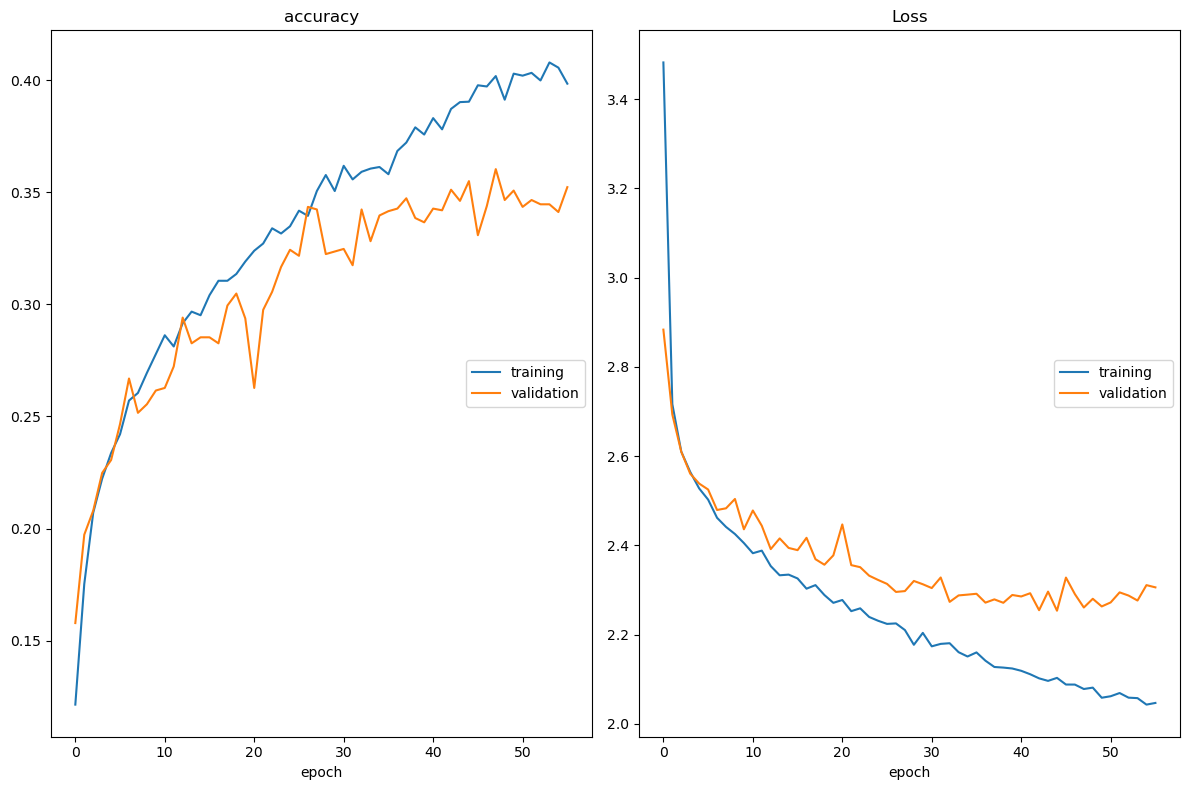

accuracy
	training         	 (min:    0.121, max:    0.408, cur:    0.399)
	validation       	 (min:    0.158, max:    0.360, cur:    0.352)
Loss
	training         	 (min:    2.043, max:    3.482, cur:    2.047)
	validation       	 (min:    2.254, max:    2.883, cur:    2.306)


KeyboardInterrupt: 

In [17]:
from livelossplot import PlotLossesKeras

batch_size = 32
epochs = 100

model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs, callbacks=[PlotLossesKeras()], verbose=0)

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, entropy
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import LabelBinarizer

types = ['pose', 'left_hand', 'right_hand']
lblBin = LabelBinarizer().fit(types)

# Initialize a list of folder names containing parquet files
folders = ["alligator", "flower", "kiss", "listen", "orange"]

# Initialize lists for aggregated data and labels
aggregated_files = []
labels = []

# Iterate over the folders in the list
for folder in folders:
    # Update path to focus on content inside folder in the current iteration
    path = "./asl-kaggle/by_labels/"+folder+"/"

    # Fetch all file names in the folder
    parquets = [f for f in listdir(path) if isfile(join(path, f))]

    # Iterate over file names in the list (up to the 50th file name)
    for parquet in parquets[:50]:
        grid_1 = np.zeros((100,100))
        grid_2 = np.zeros((100,100))
        grid_3 = np.zeros((100,100))

        # Update path to focus on the file in the current iteration
        parquet_path = path + parquet
        
        # Read the file at the path and load data to pf
        pf = pd.read_parquet(parquet_path)
        
        # Replace all NaN values with 0
        pf = pf.fillna(0)

        # Remove all rows with the type of face
        pf = pf.drop(pf.loc[pf.type=="face"].index).reset_index(drop=True)
        pf = pf.drop(['row_id', 'frame', 'landmark_index'], axis=1)

        frames_data = pf.groupby('type').apply(lambda group: group[['x','y','z']].to_numpy().tolist())


        # Find the maximum length of arrays
        max_length = max(np.array(arr).shape[0] for arr in frames_data)

        # Pad each array along the first dimension (rows)
        padded_data = [np.pad(arr, ((0, max_length - np.array(arr).shape[0]), (0, 0)), mode='mean') for arr in frames_data]

        # Convert the list of padded arrays back to a numpy array
        frames_data = np.array(padded_data)

        video_data = np.array(frames_data.tolist())

        # Append array to list
        aggregated_files.append(video_data)
        labels.append(folder)


In [ ]:
(frames_data * 100).shape